# Setup

In [19]:
from google.colab import auth
auth.authenticate_user()

In [21]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   107k      0 --:--:-- --:--:-- --:--:--  107k
OK
65 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.35.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


In [22]:
!mkdir data
!gcsfuse --implicit-dirs pose-estimation-datasets ./data/

mkdir: cannot create directory ‘data’: File exists
2021/05/18 02:14:11.087616 Using mount point: /content/data
2021/05/18 02:14:11.094903 Opening GCS connection...
2021/05/18 02:14:11.215992 Mounting file system "pose-estimation-datasets"...
2021/05/18 02:14:11.217840 File system has been successfully mounted.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import glob
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import optim
from torch.autograd import Variable


# Data Loader 

In [24]:
class AFLW2000Data(Dataset):
    def __init__(self, mode, transform=None, directory='data/AFLW2000/'):
        self.mode = mode
        self.tranform = transform
        self.image_list_open = open("data/AFLW2000_filename_filtered.txt", "r")
        self.image_list = self.image_list_open.read().splitlines()
        self.image_list.sort()
        self.images = [directory+x+'.jpg' for x in self.image_list]
        self.annotations = [directory+x+'.mat' for x in self.image_list]
        self.transform = transform
        
        self.x = {}
        self.y = {}
        self.x['train'] = self.images[:1378]
        self.y['train'] = self.annotations[:1378]
        self.x['test'] = self.images[1378:]
        self.y['test'] = self.images[1378:]
        
    def __len__(self):
        return len(self.x[self.mode])
    
    def __getitem__(self, index):
        img = Image.open(self.x[self.mode][index]).convert('RGB')
        annot = sio.loadmat(self.y[self.mode][index])
        
        # Pitch, Yaw, Roll
        pose_params = annot['Pose_Para'][0][:3]

        pitch = pose_params[0] * 180 / np.pi
        yaw = pose_params[1] * 180 / np.pi
        roll = pose_params[2] * 180 / np.pi

        labels = torch.FloatTensor([yaw, pitch, roll])
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, labels

img_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(),])

train_set = AFLW2000Data(mode='train', transform=img_transform)
val_set = AFLW2000Data(mode='val', transform=img_transform)
test_set = AFLW2000Data(mode='test', transform=img_transform)

train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

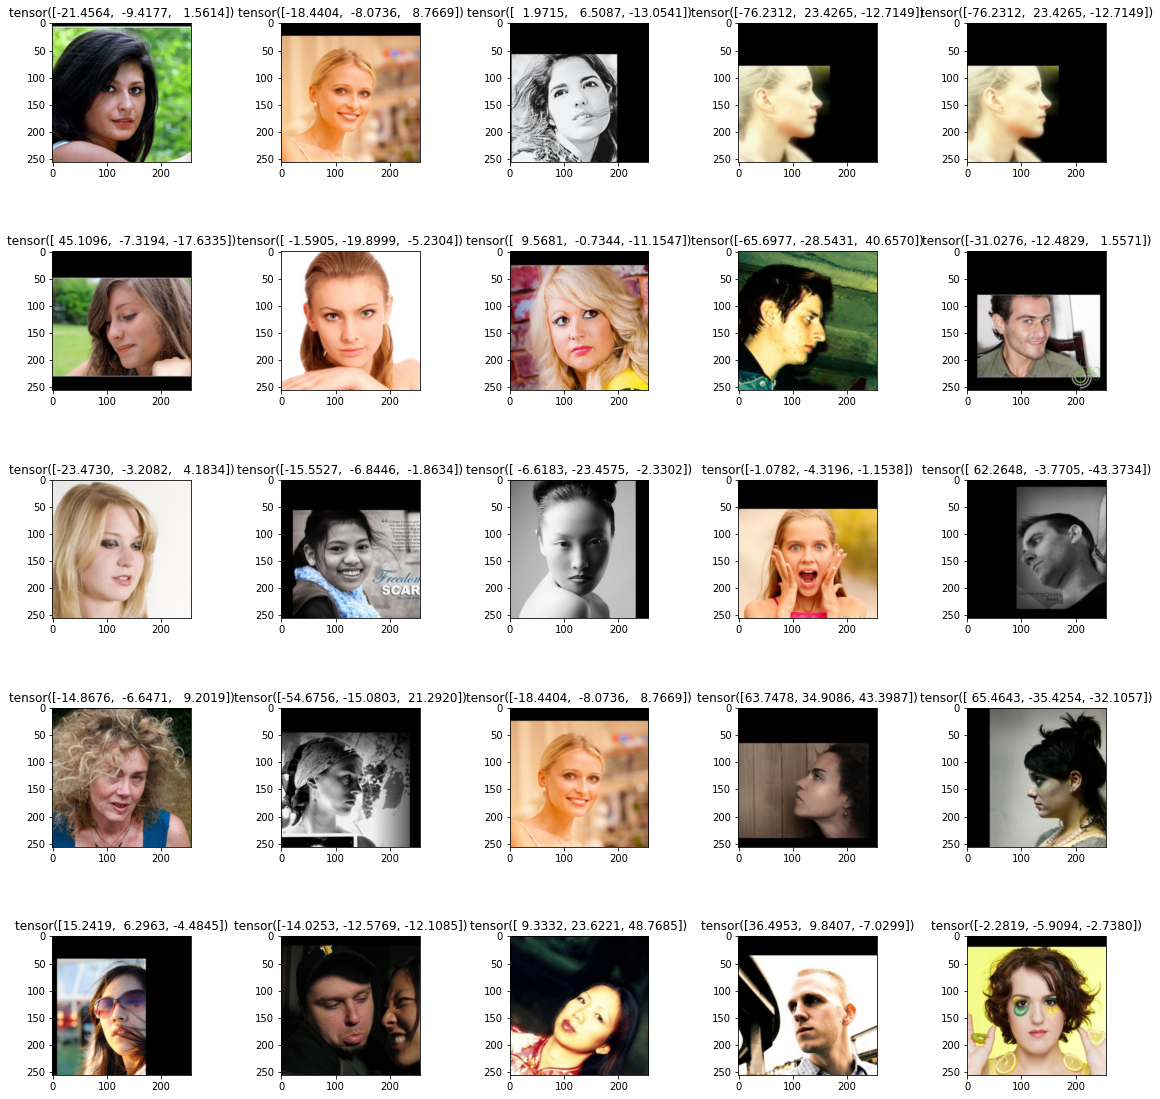

In [25]:
import cv2
fig, axs = plt.subplots(5,5,figsize=(16,16))
inds = np.random.choice(np.arange(len(train_set)), 25)
for i in range(5):
    for j in range(5):
        img, lab = train_set[inds[i*5+j]]
        img = np.moveaxis(img.numpy(), 0, -1)
        plt.imshow(img)
        axs[i][j].imshow(img)
        axs[i][j].set_title(str(lab))


fig.tight_layout()
plt.show()

# Model

In [8]:
def conv3x3(in_planes, out_planes, strd=1, padding=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=strd, padding=padding, bias=bias)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ConvBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, int(out_planes / 2))
        self.bn2 = nn.BatchNorm2d(int(out_planes / 2))
        self.conv2 = conv3x3(int(out_planes / 2), int(out_planes / 4))
        self.bn3 = nn.BatchNorm2d(int(out_planes / 4))
        self.conv3 = conv3x3(int(out_planes / 4), int(out_planes / 4))

        if in_planes != out_planes:
            self.downsample = nn.Sequential(
                nn.BatchNorm2d(in_planes),
                nn.ReLU(True),
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=1, bias=False),
            )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x

        out1 = self.bn1(x)
        out1 = F.relu(out1, True)
        out1 = self.conv1(out1)

        out2 = self.bn2(out1)
        out2 = F.relu(out2, True)
        out2 = self.conv2(out2)

        out3 = self.bn3(out2)
        out3 = F.relu(out3, True)
        out3 = self.conv3(out3)

        out3 = torch.cat((out1, out2, out3), 1)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out3 += residual

        return out3

In [10]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [11]:
class HourGlass(nn.Module):
    def __init__(self, num_modules, depth, num_features):
        super(HourGlass, self).__init__()
        self.num_modules = num_modules
        self.depth = depth
        self.features = num_features

        self._generate_network(self.depth)

    def _generate_network(self, level):
        self.add_module('b1_' + str(level), ConvBlock(self.features, self.features))

        self.add_module('b2_' + str(level), ConvBlock(self.features, self.features))

        if level > 1:
            self._generate_network(level - 1)
        else:
            self.add_module('b2_plus_' + str(level), ConvBlock(self.features, self.features))

        self.add_module('b3_' + str(level), ConvBlock(self.features, self.features))

    def _forward(self, level, inp):
        # Upper branch
        up1 = inp
        up1 = self._modules['b1_' + str(level)](up1)

        # Lower branch
        low1 = F.avg_pool2d(inp, 2, stride=2)
        low1 = self._modules['b2_' + str(level)](low1)

        if level > 1:
            low2 = self._forward(level - 1, low1)
        else:
            low2 = low1
            low2 = self._modules['b2_plus_' + str(level)](low2)

        low3 = low2
        low3 = self._modules['b3_' + str(level)](low3)

        up2 = F.interpolate(low3, scale_factor=2, mode='nearest')

        return up1 + up2

    def forward(self, x):
        return self._forward(self.depth, x)

In [12]:
class FAN(nn.Module):

    def __init__(self, num_modules=1):
        super(FAN, self).__init__()
        self.num_modules = num_modules

        # Base part
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 128)
        self.conv4 = ConvBlock(128, 256)

        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(5508, 1)
        self.fc_pitch = nn.Linear(5508, 1)
        self.fc_roll = nn.Linear(5508, 1)

        # Stacking part
        for hg_module in range(self.num_modules):
            self.add_module('m' + str(hg_module), HourGlass(1, 4, 256))
            self.add_module('top_m_' + str(hg_module), ConvBlock(256, 256))
            self.add_module('conv_last' + str(hg_module),
                            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
            self.add_module('bn_end' + str(hg_module), nn.BatchNorm2d(256))
            self.add_module('l' + str(hg_module), nn.Conv2d(256,
                                                            68, kernel_size=1, stride=1, padding=0))

            if hg_module < self.num_modules - 1:
                self.add_module(
                    'bl' + str(hg_module), nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.add_module('al' + str(hg_module), nn.Conv2d(68,
                                                                 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), True)
        x = F.avg_pool2d(self.conv2(x), 2, stride=2)
        x = self.conv3(x)
        x = self.conv4(x)

        previous = x

        outputs = []
        for i in range(self.num_modules):
            hg = self._modules['m' + str(i)](previous)

            ll = hg
            ll = self._modules['top_m_' + str(i)](ll)

            ll = F.relu(self._modules['bn_end' + str(i)]
                        (self._modules['conv_last' + str(i)](ll)), True)

            # Predict heatmaps
            tmp_out = self._modules['l' + str(i)](ll)
            outputs.append(tmp_out)

            if i < self.num_modules - 1:
                ll = self._modules['bl' + str(i)](ll)
                tmp_out_ = self._modules['al' + str(i)](tmp_out)
                previous = previous + ll + tmp_out_

       

        x = outputs[0]
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)
        

        return pre_yaw, pre_pitch, pre_roll

In [17]:
model = FAN()
model = model.cuda()
criterion = nn.L1Loss().cuda()
alpha = 1

softmax = nn.Softmax().cuda()
idx_tensor = [idx for idx in range(66)]
idx_tensor = Variable(torch.FloatTensor(idx_tensor)).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 20
batch_size = 16

train_yaw_losses = []
train_pitch_losses = []
train_roll_losses = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_dataloader):
    images = Variable(images).cuda()

    label_yaw = Variable(labels[:,0]).cuda()
    label_pitch = Variable(labels[:,1]).cuda()
    label_roll = Variable(labels[:,2]).cuda()

    # Forward pass
    yaw, pitch, roll = model(images)

    # MAE
    loss_yaw = alpha * criterion(yaw, label_yaw)
    loss_pitch = alpha * criterion(pitch, label_pitch)
    loss_roll = alpha * criterion(roll, label_roll)

    train_yaw_losses.append(loss_yaw)
    train_pitch_losses.append(loss_pitch)
    train_roll_losses.append(loss_roll)

    loss_seq = [loss_yaw, loss_pitch, loss_roll]
    grad_seq= [torch.tensor(1.0).cuda() for _ in range(len(loss_seq))]
    optimizer.zero_grad()
    torch.autograd.backward(loss_seq, grad_seq)
    optimizer.step()
    
    print ('Epoch [%d/%d], Iter [%d/%d] Losses: Yaw %.4f, Pitch %.4f, Roll %.4f' %(epoch+1, num_epochs, i+1, len(train_set)//batch_size, loss_yaw.item(), loss_pitch.item(), loss_roll.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [1/20], Iter [1/86] Losses: Yaw 40.9209, Pitch 26.1436, Roll 20.8891
Epoch [1/20], Iter [2/86] Losses: Yaw 62.3928, Pitch 30.2731, Roll 26.1316
Epoch [1/20], Iter [3/86] Losses: Yaw 28.3769, Pitch 17.8863, Roll 25.9238
Epoch [1/20], Iter [4/86] Losses: Yaw 39.8634, Pitch 26.5477, Roll 16.4492
Epoch [1/20], Iter [5/86] Losses: Yaw 46.8816, Pitch 30.7909, Roll 27.0200
Epoch [1/20], Iter [6/86] Losses: Yaw 75.1084, Pitch 35.6471, Roll 33.0893
Epoch [1/20], Iter [7/86] Losses: Yaw 41.2322, Pitch 25.2420, Roll 19.3285
Epoch [1/20], Iter [8/86] Losses: Yaw 38.6934, Pitch 23.4246, Roll 14.6450
Epoch [1/20], Iter [9/86] Losses: Yaw 83.4985, Pitch 52.9373, Roll 55.3950
Epoch [1/20], Iter [10/86] Losses: Yaw 41.5135, Pitch 11.2774, Roll 14.4263
Epoch [1/20], Iter [11/86] Losses: Yaw 51.5566, Pitch 15.6195, Roll 19.1530
Epoch [1/20], Iter [12/86] Losses: Yaw 65.7406, Pitch 20.4359, Roll 22.3038
Epoch [1/20], Iter [13/86] Losses: Yaw 69.4218, Pitch 28.2849, Roll 38.1895
Epoch [1/20], Iter [1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [2/20], Iter [1/86] Losses: Yaw 32.9533, Pitch 21.0199, Roll 21.7124
Epoch [2/20], Iter [2/86] Losses: Yaw 52.9017, Pitch 27.2081, Roll 25.1181
Epoch [2/20], Iter [3/86] Losses: Yaw 62.7296, Pitch 20.7143, Roll 20.8900
Epoch [2/20], Iter [4/86] Losses: Yaw 32.5401, Pitch 17.4034, Roll 24.5850
Epoch [2/20], Iter [5/86] Losses: Yaw 20.5906, Pitch 22.5337, Roll 14.4213
Epoch [2/20], Iter [6/86] Losses: Yaw 45.2200, Pitch 29.2501, Roll 39.6082
Epoch [2/20], Iter [7/86] Losses: Yaw 45.9804, Pitch 26.1074, Roll 24.9664
Epoch [2/20], Iter [8/86] Losses: Yaw 61.8571, Pitch 27.4010, Roll 33.9011
Epoch [2/20], Iter [9/86] Losses: Yaw 42.5737, Pitch 26.1191, Roll 36.5469
Epoch [2/20], Iter [10/86] Losses: Yaw 48.1277, Pitch 31.0562, Roll 20.7064
Epoch [2/20], Iter [11/86] Losses: Yaw 46.5822, Pitch 20.4672, Roll 15.7175
Epoch [2/20], Iter [12/86] Losses: Yaw 37.9538, Pitch 14.0343, Roll 14.6871
Epoch [2/20], Iter [13/86] Losses: Yaw 33.0365, Pitch 19.0714, Roll 16.5458
Epoch [2/20], Iter [1

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(train_yaw_losses)
plt.plot(train_pitch_losses)
plt.plot(train_roll_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Train Loss')
plt.show()

In [18]:
torch.save(model.state_dict(), 'FAN_20epochs.pt')